In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from graph.structure.graph import Graph
from graph.prior.sparse_prior import SparsePrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.masked_gaussian_measurement import MaskedGaussianMeasurement
from core.metrics import mse
from core.linalg_utils import random_unitary_matrix, random_binary_mask

In [3]:
n = 512
sparsity = 0.1
noise_var = 1e-4
mask_ratio = 0.2

np.random.seed(0)
true_x = np.zeros(n, dtype=np.complex128)
nonzero = np.random.choice(n, int(n * sparsity), replace=False)
true_x[nonzero] = (np.random.randn(len(nonzero)) + 1j * np.random.randn(len(nonzero))) / np.sqrt(2)

U = random_unitary_matrix(n, seed=0)
true_y = U @ true_x
noise = (np.random.randn(n) + 1j * np.random.randn(n)) * np.sqrt(noise_var / 2)
observed = true_y + noise
mask = random_binary_mask(n, subsampling_rate=mask_ratio, seed=0)

In [4]:
class CompressiveSensingGraph(Graph):
    def __init__(self, U, observed, var, mask, rho):
        super().__init__()
        self.X = SparsePrior(rho=rho, shape=(n,), damping=0.05)
        self.Y = UnitaryPropagator(U) @ self.X
        self.Z = MaskedGaussianMeasurement(self.Y, observed, var=var, mask=mask)
        self.compile()

cs_graph = CompressiveSensingGraph(U = U, observed = observed, var = noise_var, mask = mask, rho = sparsity)

def monitor(graph, t):
    x_est = graph.X.compute_belief().data
    err = mse(x_est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

cs_graph.run(n_iter=20, callback=monitor)

[t=0] MSE = 3.72771e-01
[t=5] MSE = 2.42589e-02
[t=10] MSE = 7.89710e-03
[t=15] MSE = 6.18840e-04


In [5]:
cs_graph.summary()

Graph Summary:
- 2 Wave nodes
- 3 Factor nodes


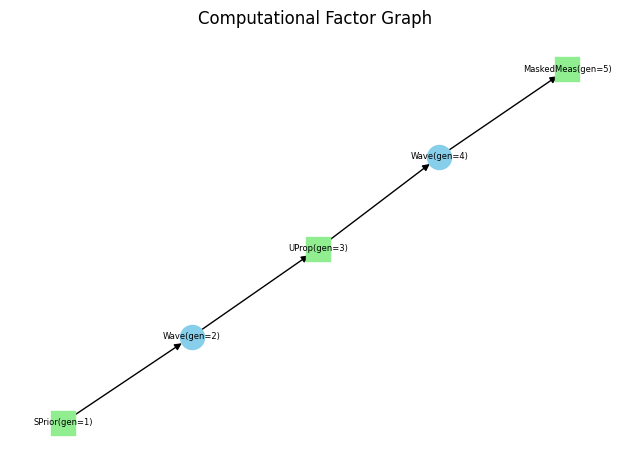

In [6]:
cs_graph.visualize(layout="kamada_kawai", font_size=6, scale=2.0)